In [ ]:
#import pyarrow.feather as feather
import pandas as pd
import numpy as np
#from scipy.io import netcdf
import matplotlib.pyplot as plt 
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(color_codes=True)


In [3]:
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [4]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        try:
            new_columns.append(pd.to_datetime(col).date())
        except: new_columns.append(col)
    return new_columns

In [5]:
###########################################################################################################

In [6]:
# import sample6
grouped_t_s= pd.read_csv(f"dataset/modeling/sample6/ts.csv").set_index("proj_id")
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
ave_temp= pd.read_csv(f"dataset/modeling/sample6/temp.csv").set_index("proj_id")
ave_temp.columns = convert_col_to_date(ave_temp.columns)
cum_prec= pd.read_csv(f"dataset/modeling/sample6/prec.csv").set_index("proj_id")
cum_prec.columns = convert_col_to_date(cum_prec.columns)
print(grouped_t_s.shape)
print(ave_temp.shape)
print(cum_prec.shape)

(9, 6546)
(9, 6546)
(9, 6546)


# func

In [7]:
# create df for a t s (one row in grouped_t_s df)
def create_one_ts_df(row):
    bgr = row.name
    idx = row.dropna().index[2:]
    ts = row[idx]
    temp = ave_temp[idx].loc[bgr]
    prec = cum_prec[idx].loc[bgr]
    df = pd.DataFrame({"ts":ts,"temp": temp,"prec":prec, })
    return df


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def split_df(reframed):
    # split into train and test sets, 
    values = reframed.values
    n_train = int(len(reframed)*0.95)
    train = values[:n_train, :]
    test = values[n_train:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, train_y, test_X, test_y


# pick t s

ts length:3815.0, freq: 1.0
(3784, 3)


Text(0.5, 1.0, 'prec')

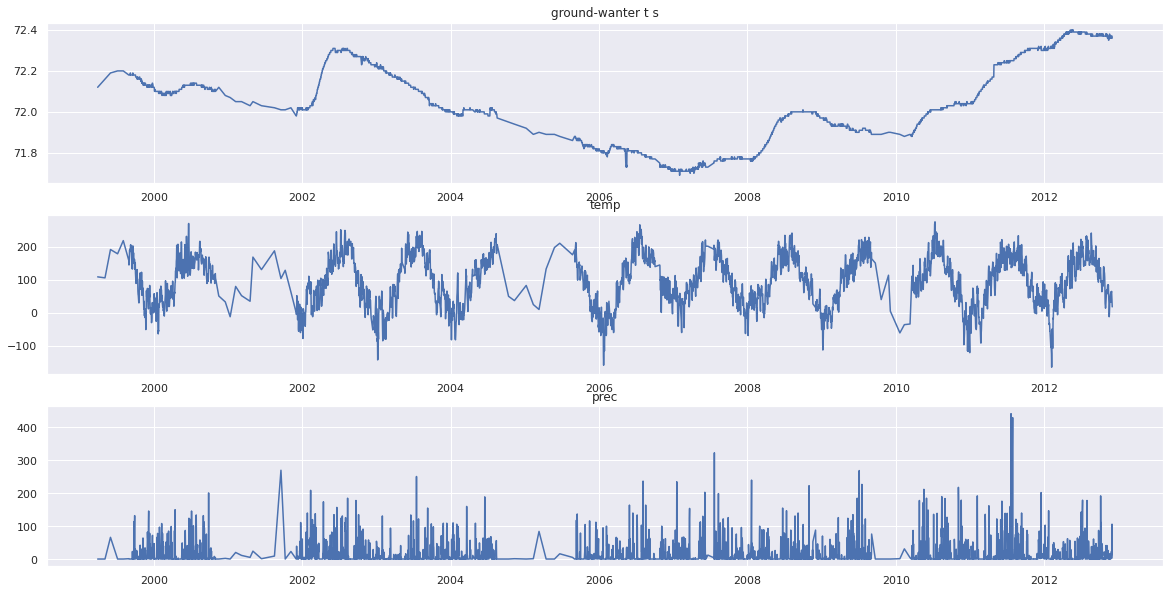

In [8]:
# apply the func
ts1 = grouped_t_s.loc["BB_27471020"]
print(f"ts length:{ts1[0]}, freq: {ts1[1]}")
df = create_one_ts_df(ts1)
print(df.shape)
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 0,4000
axs[0].plot(df["ts"][a:b])
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')

In [9]:
df

,ts,temp,prec
1999-03-31,72.12,109.0,0.0
1999-05-06,72.16,106.0,0.0
1999-06-02,72.19,192.0,66.0
1999-07-07,72.20,179.0,0.0
1999-08-04,72.20,219.0,0.0
...,...,...,...
2012-11-26,72.37,62.0,23.0
2012-11-27,72.37,65.0,2.0
2012-11-28,72.37,50.0,10.0
2012-11-29,72.37,40.0,106.0


# apply

In [10]:
# convert the df to match lstm data
# load dataset
lag=30
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled.shape

(3784, 3)

In [11]:
# frame as supervised learning
reframed = series_to_supervised(scaled, lag, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[-2:], axis=1, inplace=True)
print(reframed.shape)
reframed.index= df.index[lag:]
reframed.head()

(3754, 91)


,var1(t-30),var2(t-30),var3(t-30),var1(t-29),var2(t-29),var3(t-29),var1(t-28),var2(t-28),var3(t-28),var1(t-27),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t)
1999-09-25,0.605637,0.621315,0.000000,0.661980,0.614512,0.000000,0.704231,0.809524,0.149321,0.718307,...,0.69014,0.757370,0.002262,0.69014,0.786848,0.004525,0.69014,0.784580,0.000000,0.69014
1999-09-26,0.661980,0.614512,0.000000,0.704231,0.809524,0.149321,0.718307,0.780045,0.000000,0.718307,...,0.69014,0.786848,0.004525,0.69014,0.784580,0.000000,0.69014,0.748299,0.002262,0.69014
1999-09-27,0.704231,0.809524,0.149321,0.718307,0.780045,0.000000,0.718307,0.870748,0.000000,0.690140,...,0.69014,0.784580,0.000000,0.69014,0.748299,0.002262,0.69014,0.718821,0.257919,0.69014
1999-09-28,0.718307,0.780045,0.000000,0.718307,0.870748,0.000000,0.690140,0.734694,0.002262,0.690140,...,0.69014,0.748299,0.002262,0.69014,0.718821,0.257919,0.69014,0.712018,0.000000,0.69014
1999-09-29,0.718307,0.870748,0.000000,0.690140,0.734694,0.002262,0.690140,0.702948,0.002262,0.690140,...,0.69014,0.718821,0.257919,0.69014,0.712018,0.000000,0.69014,0.741497,0.214932,0.69014


In [12]:
################################################################
# split the data
train_X, train_y, test_X, test_y= split_df(reframed)

print("input to be 3D [samples, timesteps(lag, features]\n")
print(f"train: {train_X.shape} , {train_y.shape} ,test: {test_X.shape} , {test_y.shape}")
####################################################################


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False)

##############################################################################


input to be 3D [samples, timesteps(lag, features]

train: (3566, 1, 90) , (3566,) ,test: (188, 1, 90) , (188,)
Epoch 1/100
50/50 - 4s - loss: 0.1919 - val_loss: 0.0910
Epoch 2/100
50/50 - 0s - loss: 0.1500 - val_loss: 0.1871
Epoch 3/100
50/50 - 0s - loss: 0.1296 - val_loss: 0.2961
Epoch 4/100
50/50 - 0s - loss: 0.1105 - val_loss: 0.2132
Epoch 5/100
50/50 - 0s - loss: 0.0912 - val_loss: 0.1278
Epoch 6/100
50/50 - 0s - loss: 0.0991 - val_loss: 0.2070
Epoch 7/100
50/50 - 0s - loss: 0.0890 - val_loss: 0.1367
Epoch 8/100
50/50 - 0s - loss: 0.0781 - val_loss: 0.1052
Epoch 9/100
50/50 - 0s - loss: 0.0933 - val_loss: 0.1968
Epoch 10/100
50/50 - 0s - loss: 0.0763 - val_loss: 0.1048
Epoch 11/100
50/50 - 0s - loss: 0.0713 - val_loss: 0.1097
Epoch 12/100
50/50 - 0s - loss: 0.0877 - val_loss: 0.1647
Epoch 13/100
50/50 - 0s - loss: 0.0646 - val_loss: 0.0784
Epoch 14/100
50/50 - 0s - loss: 0.0758 - val_loss: 0.1494
Epoch 15/100
50/50 - 0s - loss: 0.0729 - val_loss: 0.1186
Epoch 16/100
50/50 - 0s - lo

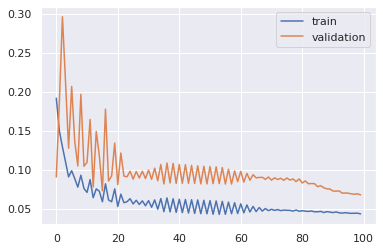

In [13]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


# for outliers

In [14]:
# make a prediction
train_y_pred = model.predict(train_X)
train_y = train_y.reshape(train_y_pred.shape[0],train_y_pred.shape[1])
scored = pd.DataFrame(index=reframed.index[:len(train_y)]) 
scored['Loss_mae'] = np.abs(train_y - train_y_pred)
scored

,Loss_mae
1999-09-25,0.031383
1999-09-26,0.035691
1999-09-27,0.035390
1999-09-28,0.036088
1999-09-29,0.036086
...,...
2012-05-22,0.080061
2012-05-23,0.066483
2012-05-24,0.067599
2012-05-25,0.071148


(0.0, 0.25)

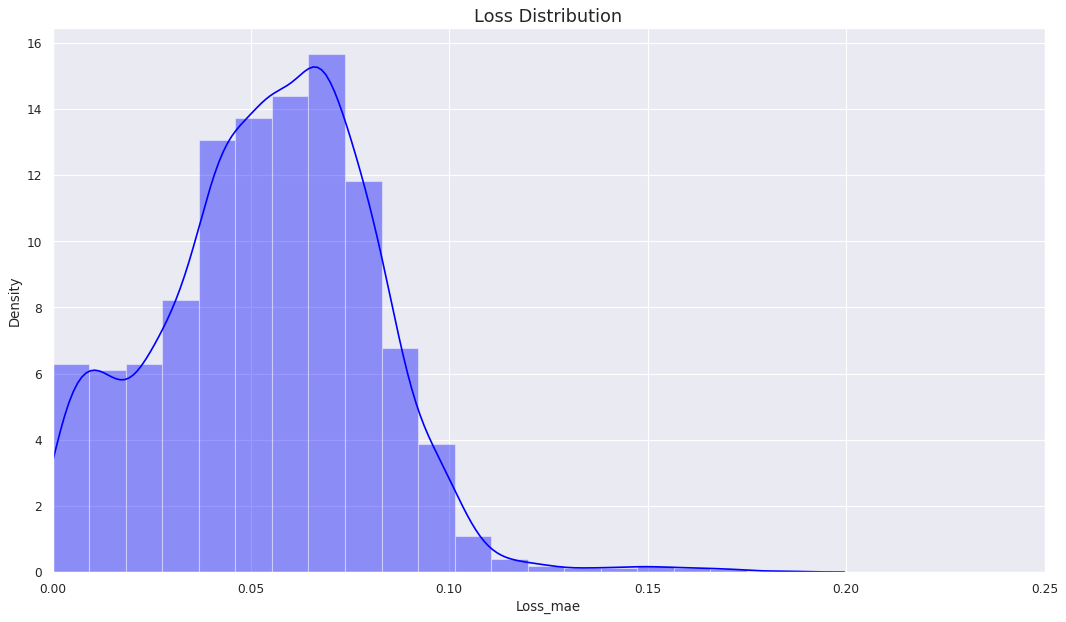

In [17]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.25])

In [18]:
thre = np.mean(scored,axis=0)[0]+4*np.std(scored,axis=0)[0];thre

0.15915990993380547

In [19]:
# make a prediction test
test_y_pred = model.predict(test_X)
test_y = test_y.reshape(test_y_pred.shape[0],test_y_pred.shape[1])
scored_test = pd.DataFrame(index=reframed.index[len(train_y):]) 
scored_test['Loss_mae'] = np.abs(test_y - test_y_pred)
scored_test

,Loss_mae
2012-05-27,0.071282
2012-05-28,0.072408
2012-05-29,0.072682
2012-05-30,0.069821
2012-05-31,0.069843
...,...
2012-11-26,0.013207
2012-11-27,0.013287
2012-11-28,0.015730
2012-11-29,0.016017


In [20]:
scored = pd.concat([scored,scored_test])
scored['Anomaly'] = scored['Loss_mae'] > thre
scored = scored.sort_values(by="Loss_mae", ascending=False)
scored

,Loss_mae,Anomaly
2005-08-23,0.184187,True
2005-02-11,0.172105,True
2006-05-14,0.172003,True
2006-05-13,0.169282,True
2005-06-21,0.163591,True
...,...,...
2002-03-27,0.000179,False
2003-07-22,0.000146,False
2000-07-05,0.000144,False
2000-07-28,0.000128,False


In [21]:
print(scored[scored["Anomaly"]==True].shape)
scored[scored["Anomaly"]==True]

(8, 2)


,Loss_mae,Anomaly
2005-08-23,0.184187,True
2005-02-11,0.172105,True
2006-05-14,0.172003,True
2006-05-13,0.169282,True
2005-06-21,0.163591,True
2005-04-15,0.161611,True
2006-05-12,0.161561,True
2001-12-02,0.161026,True


In [22]:
anomaly = scored[scored["Anomaly"]==True].index
anomaly

Index([2005-08-23, 2005-02-11, 2006-05-14, 2006-05-13, 2005-06-21, 2005-04-15,
       2006-05-12, 2001-12-02],
      dtype='object')

In [23]:
scored.loc[pd.to_datetime("2006, 5, 14").date()]

Loss_mae    0.172003
Anomaly         True
Name: 2006-05-14, dtype: object

<IPython.core.display.Javascript object>


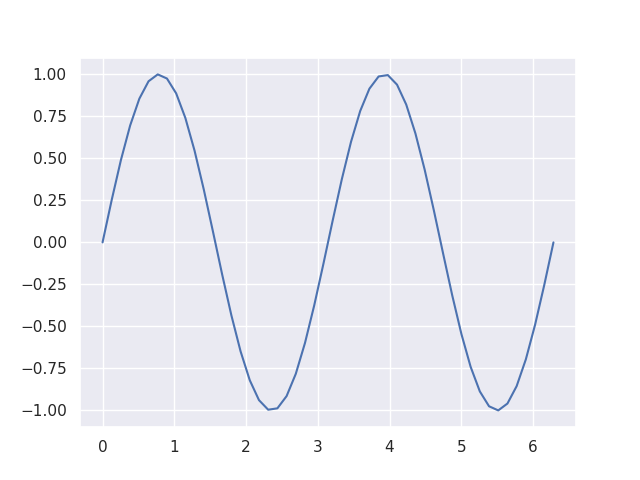

interactive(children=(FloatSlider(value=2.0, description='w', max=6.0, min=-2.0), Output()), _dom_classes=('wi…

In [24]:
%matplotlib notebook
from ipywidgets import *

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 2.):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw_idle()

interact(update);

<IPython.core.display.Javascript object>


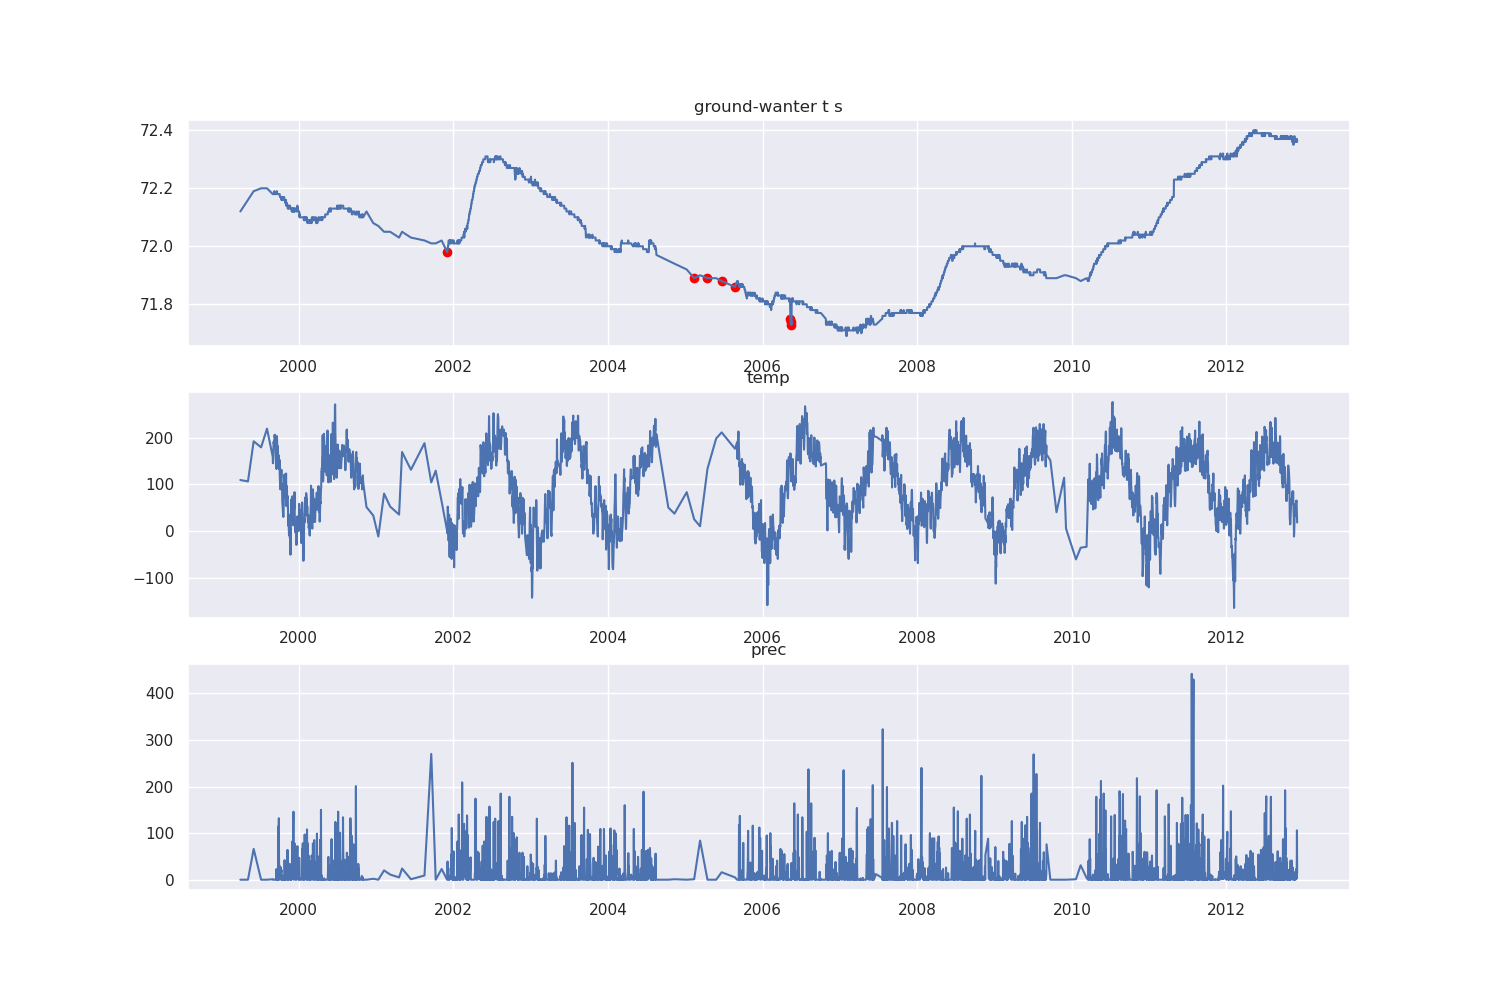

Text(0.5, 1.0, 'prec')

In [25]:
# plot a t s with its predictors
#%matplotlib widget
fig, axs = plt.subplots(3,1, figsize=(15,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 0,5000
out1, out2 =0,700
#a,b = 220,320
axs[0].plot(df["ts"][a:b])
axs[0].scatter(anomaly[out1:out2], df["ts"][anomaly][out1:out2], color="red")
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')

# for prediction

In [ ]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = scaler.inverse_transform(np.concatenate((yhat, test_X[:, 1:]), axis=1))[:,0]
#inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = scaler.inverse_transform(np.concatenate((test_y, test_X[:, 1:]), axis=1))[:,0]
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
#####################################################################



In [ ]:
print(f"std ts: {np.std(ts1.dropna())}")
print(f"std test_y: {np.std(inv_y)}")

In [ ]:
fd = pd.DataFrame([inv_y, inv_yhat]).T[:]
fd.columns = ["test_y", "predicted"]
fd.iloc[0:200].plot(figsize=(10,5))